<a href="https://colab.research.google.com/github/papapabi/wandb-experiments/blob/main/nlp_aes_holistic_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Exam Scoring - Holistic

Task: assigning a discrete value (a single integer score from 1-6 due to dataset) for an entire essay

## Setup

In [ ]:
!pip install wandb==0.23.0 evaluate datasets transformers

In [ ]:
import os
from google.colab import userdata

# Declare a Secret in Colab and paste your own W&B API key
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
# Optional: declare a Secret in Colab and paste your own HF access token
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

import wandb

wandb.login()

## Dataset and methodology scratchpad

[Automated Student Assessment Prize (ASAP 2.0)](https://github.com/scrosseye/ASAP_2.0) - from Kaggle
- persuasive essays written by 6th, 8th, 9th, and 10th grade students, with 7 writing prompts in total
- this is slightly modified from the [original competition dataset](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2), which only contained essay_id, full_text, and score
- ~24728 unique rows (verified below) - we need to make train/val/test splits ourselves
- columns of interest/input features
    - score ([holistic score description](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf)) - an integer in the range [1, 6]
    - full_text - actual essay content
    - essay_id - can be used to check for uniqueness/deduplication
- other columns/metadata provided not in the original competition dataset: economically_disadvantaged, student_disability_status, ell_status, race_ethnicity, gender
    - Using these as input features effectively encodes discrimination into the system, so they should not be used as input features
    - But we can use them to check and prove that the fine-tuned model is not biased to any of these metadata - **for future work**
- other interesting/to-explore columns:
    - assignment - the writing prompt to produce the essay - find a way to incorporate this into fine-tuning and inference - **for future work**
        - one way is to do prompt-based fine-tuning, by prepending the raw prompt text or ID-encoded prompt before the essay (full_text)
    - source_text_[1-4] - contains the reference reading passages that students were expected to use, analyze, summarize, or respond to in their essays

Metric: [Quadratic Weighted Kappa (QWK)](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview/evaluation) - it effectively penalizes larger score discrepancies more heavily than smaller ones, reflecting the ordinal nature of essay scores (e.g., assigning a score of 6 to a true value of 1 is a bigger error than assigning 3 vs. 1)
- going with this, the loss function needs to reflect that ordinal nature too (see later section Ordinal regression - CORAL)
- according to https://arxiv.org/html/2509.10417v1, human-human rater agreement has a QWK at 0.745, so we have a concrete target.


Immediates:
1. check for nans and undesirables in columns of interest - no undesirables ✅
2. check for uniqueness using essay_id - all texts are unique ✅
2. full_text - estimate token length via simple estimate of word length to determine if we need to get creative with a tokenizer (head+tail truncation, sliding window) or use a transformer with a large context window like longformer

Model candidates post-EDA:
- 99% of the dataset (full_text) falls below ~1216 tokens (computed via a heuristic)
    - pretrained model candidates - `ModernBERT` (can handle sequence lengths up to 8192 tokens), `microsoft/deberta-v3-*`, `longformer`, `edubert` - going with `ModernBERT` for now

## Get dataset from Kaggle


In [ ]:
!pip install kagglehub

To execute the following cells, you must set a Colab Secret named `KAGGLE_API_TOKEN` in your notebook environment:

In [ ]:
import kagglehub
from google.colab import userdata
import os

os.environ["KAGGLE_API_TOKEN"] = userdata.get("KAGGLE_API_TOKEN")

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

raw_dataset = kagglehub.dataset_load(
    KaggleDatasetAdapter.HUGGING_FACE,
    "lburleigh/asap-2-0",
    "ASAP2_train_sourcetexts.csv",
)

100%|██████████| 199M/199M [00:04<00:00, 51.1MB/s]


In [ ]:
raw_dataset

Dataset({
    features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
    num_rows: 24728
})

## Exploratory data analysis (EDA)

### Check for NaNs and invalid values in columns of interest

In [ ]:
def check_invalid_counts(dataset):
    ds = dataset

    # Check for NaNs or out-of-range in 'score'
    invalid_score = ds.filter(lambda x: x['score'] is None or x['score'] not in [1, 2, 3, 4, 5, 6])
    # Check for NaNs or non-string/empty in 'full_text'
    invalid_text = ds.filter(lambda x: x['full_text'] is None or not isinstance(x['full_text'], str) or len(x['full_text'].strip()) == 0)
    # Check for NaNs or non-string/empty in 'assignment'
    invalid_assignment = ds.filter(lambda x: x['assignment'] is None or not isinstance(x['assignment'], str) or len(x['assignment'].strip()) == 0)

    print(f"Total rows: {len(ds)}")
    print(f"Invalid scores: {len(invalid_score)}")
    print(f"Invalid/empty text: {len(invalid_text)}")
    print(f"Invalid/empty assignment: {len(invalid_assignment)}")

check_invalid_counts(raw_dataset)

Filter:   0%|          | 0/24728 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24728 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24728 [00:00<?, ? examples/s]

Total rows: 24728
Invalid scores: 0
Invalid/empty text: 0
Invalid/empty assignment: 0


### Check for duplicates using essay_id

Fast check before doing anything else:

In [ ]:
num_rows = len(raw_dataset)
num_unique = len(raw_dataset.unique("essay_id"))

if num_rows > num_unique:
    print(f"⚠️ Found {num_rows - num_unique} duplicates!")
else:
    print("✅ All essay_id values are unique.")

✅ All essay_id values are unique.


### Check word length as a heuristic for token length

Goal: check 95th and 99th percentile (descriptive stats in general) of a derived `word_count` column, using the simple `str.split()` as a heuristic for token count, keeping in mind that subword tokenization used by most models typically produces 1.3-1.5 tokens per word.

In [ ]:
def count_words(batch: dict[str, list]) -> dict[str, list]:
    batch['word_count'] = [len(e.split()) for e in batch['full_text']]
    # using 1.5 as a worst-case upper bound
    batch['approximate_token_count'] = [e*1.5 for e in batch['word_count']]
    return batch

# Apply to the dataset
raw_dataset = raw_dataset.map(count_words, batched=True)

Map:   0%|          | 0/24728 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

token_counts = raw_dataset['approximate_token_count']

print(f"Mean token count: {np.mean(token_counts):.2f}")
print(f"Median token count: {np.median(token_counts)}")
print(f"Max token count: {np.max(token_counts)}")
print(f"90th percentile: {np.percentile(token_counts, 90)}")
print(f"95th percentile: {np.percentile(token_counts, 95)}")
print(f"99th percentile: {np.percentile(token_counts, 99)}")

Mean token count: 544.35
Median token count: 507.0
Max token count: 2484.0
90th percentile: 837.0
95th percentile: 963.0
99th percentile: 1216.5


Visualize the distribution and mark common model context window/`max_pos_embeddings` limits:

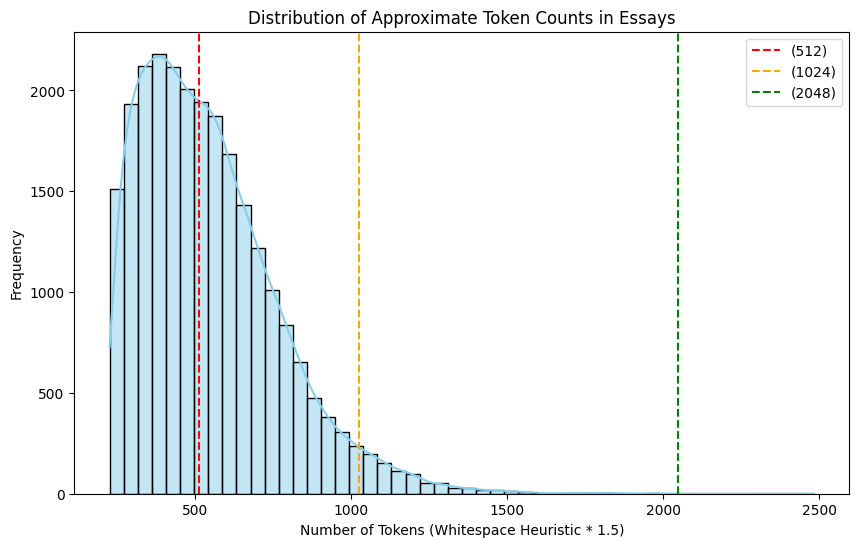

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(token_counts, bins=50, kde=True, color='skyblue')

# Context window markers for common models
plt.axvline(512, color='red', linestyle='--', label='(512)')
plt.axvline(1024, color='orange', linestyle='--', label='(1024)')
plt.axvline(2048, color='green', linestyle='--', label='(2048)')
#plt.axvline(8192, color='pink', linestyle='--', label='(8192)')

plt.title("Distribution of Approximate Token Counts in Essays")
plt.xlabel("Number of Tokens (Whitespace Heuristic * 1.5)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Insights:
- the ASAP 2.0 dataset is already cleaned and mostly ready pre-tokenization and encoding
- data has a significant long tail, with the longest essay being ~2484 tokens
- a model under the traditional BERT family (~512 tokens) will truncate nearly half (acc to median) of the essays unless a custom truncation/tokenization strategy is used such as head-tail or sliding window
    - with standard truncation, a model will effectively grade the essay while possibly ignoring the entire conclusion
- 99% of the data falls below ~1216 tokens
    - pretrained model candidates - `ModernBERT` (can handle sequence lengths up to 8192 tokens), `microsoft/deberta-v3-*`, `longformer`

### Check the distribution of 'score' column

In [ ]:
import pandas as pd

raw_dataset.set_format('pandas')
df = raw_dataset[:]

# Get counts and percentages
distribution = df['score'].value_counts(normalize=False).sort_index()
percentages = df['score'].value_counts(normalize=True).sort_index() * 100

print(pd.concat([distribution, percentages], axis=1, keys=['Count', 'Percentage (%)']))

raw_dataset.reset_format()

       Count  Percentage (%)
score                       
1       1751        7.081042
2       6847       27.689259
3       9021       36.480912
4       5553       22.456325
5       1356        5.483662
6        200        0.808800


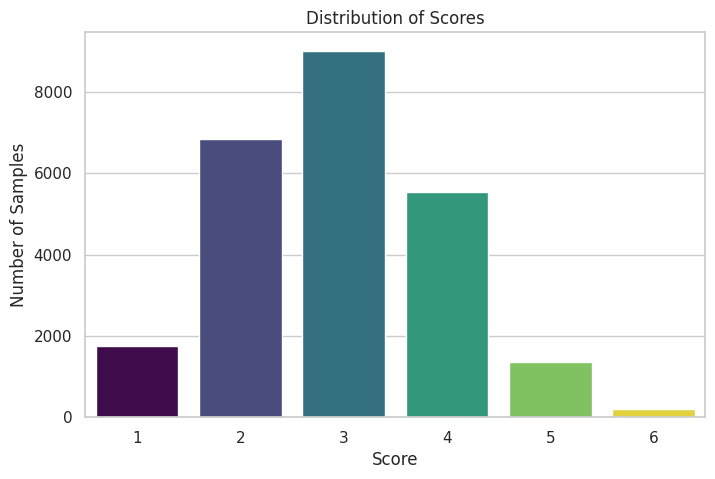

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_theme(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.countplot(x=raw_dataset['score'], hue=raw_dataset['score'], palette="viridis", legend=False)

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Number of Samples')
plt.show()

Scores 1, 5, and 6 are rare so we have to take care of preserving this distribution when we split the dataset into train/val/test.

## Sequential stratified sampling to split the raw dataset into train/val/test

Goal: 60/20/20 train/val/test split for the resulting `datasets.DatasetDict` with distributions for `score` preserved as much as possible.

Why?
- Validation and test scores will be more representative of the model's true performance across the entire range of possible scores.
- Stratification ensures 'rare' scores are represented in every split (according to EDA above, only  0.808800% got a perfect score of 6)
- Prevents the accidental case due to sheer bad luck where we end up with no examples in a split (e.g., no score 6 in the test or val set)

### Cast the 'score' column prior to stratification

We need to cast the 'score' column into a `datasets.ClassLabel` column to be able to do straified sampling.

Using the names provided by the [rubric](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf):

In [ ]:
from datasets import ClassLabel, Features

# Shift values from 1-6 to 0-5, since datasets.ClassLabel expects 0-indexed values
ds = raw_dataset.map(lambda x: {"score": x["score"] - 1})

# Define the new ClassLabel feature
# The names list corresponds to the labels for 0, 1, 2, 3, 4, 5
new_features = raw_dataset.features.copy()
new_features["score"] = ClassLabel(names=['very little mastery', 'little mastery', 'developing mastery', 'adequate mastery', 'reasonably consistent mastery', 'clear and consistent mastery'])

# Cast the column
ds = ds.cast_column("score", new_features["score"])

Map:   0%|          | 0/24728 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/24728 [00:00<?, ? examples/s]

In [ ]:
# Quick verification
print(f"{ds.features["score"]=}")
print(f"{ds[0]["score"]=}")  # Returns the integer (0-5)
print(ds.features["score"].int2str(ds[0]["score"])) # Returns the string label

ds.features["score"]=ClassLabel(names=['very little mastery', 'little mastery', 'developing mastery', 'adequate mastery', 'reasonably consistent mastery', 'clear and consistent mastery'])
ds[0]["score"]=3
adequate mastery


### Stratified sampling to get train/val/test

In [ ]:
# after this stage, ds returns a datasets.DatasetDict with 'train' and 'test' keys
# the split with the 'test' key will be our temporary pool to split again to get the final 'val' and 'test' keys
temp_dataset_dict = ds.train_test_split(
    test_size=0.4,
    shuffle=True,
    stratify_by_column="score",
    seed=42,
)

In [ ]:
val_test_dict = temp_dataset_dict["test"].train_test_split(
    test_size=0.5,  # 50% of the remaining 40%, resulting in 20% for validation, and 20% for test
    shuffle=True,
    stratify_by_column="score",
    seed=42,
)

In [ ]:
from datasets import DatasetDict

dataset_dict = DatasetDict(
    {
        'train': temp_dataset_dict['train'],
        'validation': val_test_dict['train'],
        'test': val_test_dict['test'],
    }
)

In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approx

Quick sanity check to see if the distribution was actually preserved:

In [ ]:
import pandas as pd
from datasets import DatasetDict


def calculate_distribution_percentages(
    dataset_dict: DatasetDict, label_column: str = "score"
) -> pd.DataFrame:
    """
    Calculates the percentage distribution for each split in a DatasetDict.
    """
    distribution_data = {}

    for split_name, dataset in dataset_dict.items():
        # get label counts for a particular split
        counts = dataset.to_pandas()[label_column].value_counts()
        total = len(dataset)
        percentages = (counts / total) * 100
        distribution_data[split_name] = percentages

    # Convert the results to a DataFrame for easy comparison
    distribution_df = pd.DataFrame(distribution_data).fillna(0)

    # Sort by class label for consistent viewing
    distribution_df.sort_index(inplace=True)

    return distribution_df


distribution_table = calculate_distribution_percentages(dataset_dict)


print("Class Distribution Comparison (Percentages %)")
print(distribution_table.round(2))

Class Distribution Comparison (Percentages %)
       train  validation   test
score                          
0       7.08        7.10   7.08
1      27.69       27.68  27.70
2      36.48       36.47  36.49
3      22.46       22.46  22.44
4       5.49        5.48   5.48
5       0.81        0.81   0.81


## Encode text (tokenize + encode)

`transformers.Trainer` expects the `score` column to be named `labels`:

In [ ]:
final_dataset_dict = dataset_dict.rename_column("score", "labels")

In [ ]:
from transformers import AutoTokenizer

checkpoint = 'answerdotai/ModernBERT-base'
max_pos_embeddings = 8192 # modernbert max sequence length

tokenizer = AutoTokenizer.from_pretrained(
    checkpoint
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Defer padding and use dynamic padding later:

In [ ]:
def encode_text(batch: dict[str, list]) -> dict[str, list]:
    return tokenizer(batch['full_text'], truncation=True, max_length=max_pos_embeddings)

In [ ]:
encoded_datasets = final_dataset_dict.map(
    encode_text, batched=True,
)

Map:   0%|          | 0/14836 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

In [ ]:
encoded_datasets

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'labels', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count', 'input_ids', 'attention_mask'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['essay_id', 'labels', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count', 'input_ids', 'attention_mask'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['essay_id', 'labels', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source

The only pertinent columns for fine-tuning are `labels`, `input_ids`, and `attention_mask`.

## Ordinal regression - CORAL

COnsistent RAnk Logits (CORAL) is a methodology for doing ordinal regression using neural networks. In ordinal regression, target labels have a meaningful order (like in our case, original scores are 1-6 which was mapped to zero-indexed 0-5), but the difference between ranks is not uniform or continuous like in standard regression tasks.

The key feature of the CORAL method is that it transforms the ordinal regression problem into **a series of binary classification tasks while enforcing a weight-sharing constraint in the final layer of the neural network.** This ensures that the predictions are rank-consistent, meaning the model is less likely to predict a higher rank when a lower rank would be more appropriate given the data.
- This will be explained thoroughly later on in a dedicated section

Regression vs CORAL
- While regression often implies predicting a continuous value, the CORAL method falls under the specific category of ordinal regression, which sits between classification and continuous regression.
- It leverages the ordered nature of the labels, providing more structured and better-calibrated predictions than simple scalar regression which treats labels as arbitrary continuous numbers.

In our case, it'll force the model to learn that a score of 4 is greater than 3, which is greater than 2, and so on, which standard classification ignores.


Links and references for the methodology:
- https://github.com/Raschka-research-group/coral-pytorch
- https://arxiv.org/abs/2111.08851

### Label encoding

Transform the integer labels (0-5) into a binary vector of length (5).

- 0 > [0, 0, 0, 0, 0]
- 1 > [1, 0, 0, 0, 0]
- 2 > [1, 1, 0, 0, 0]
- 3 > [1, 1, 1, 0, 0]
- 4 > [1, 1, 1, 1, 0]
- 5 > [1, 1, 1, 1, 1]

In [ ]:
def encode_ordinal_labels(batch: dict[str, list]) -> dict[str, list]:
    # Map 0 -> [0,0,0,0,0], 1 -> [1,0,0,0,0], ..., 5 -> [1,1,1,1,1]
    labels = np.array(batch["labels"])
    ordinal_labels = []
    for lbl in labels:
        # Create a vector of 5: fill 'lbl' number of slots with 1s
        vec = [1] * lbl + [0] * (5 - lbl)
        ordinal_labels.append(vec)

    batch["labels"] = ordinal_labels
    return batch

In [ ]:
label_encoded_datasets = encoded_datasets.map(encode_ordinal_labels, batched=True)

Map:   0%|          | 0/14836 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

## Defining a transformer that understands the Ordinal Regression task

We need to create a class that wraps the base model and add a custom head that understands the CORAL encodings.

By using `self.fc = nn.Linear(hidden_size, 1, bias=False)` and adding a bias vector of length 5 (num of labels - 1), we guarantee that the "importance" of the features is the same for every threshold, which is the core of ordinal logic.

We also add some flags for checkpointing so `Trainer` can talk to `self.transformer` to handle `gradient_checkpointing=True`.

NOTE: this is just the skeleton code and is subject to finalization during actual fine-tuning logic later on:

In [ ]:
from transformers import PreTrainedModel, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch

# inherit from PreTrainedModel instead of nn.Module to avoid a lot of the nastiness
# that comes with doing it that way
# we gain: automatic config.json saving, native gradient checkpointing, etc.
class TransformerOrdinal(PreTrainedModel):
    # This tells HF which config class to use
    config_class = AutoConfig
    # This prefix helps with weight loading/saving mapping
    # by setting base_model_prefix, we tell HuggingFace how to map the weights
    # so we can switch between any encoder-only architecture (ModernBERT to DeBERTa to whatever)
    base_model_prefix = "transformer"

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        # Generic AutoModel that adapts to the config provided
        self.transformer = AutoModel.from_config(config)

        hidden_size = config.hidden_size
        # CORAL Ordinal Head
        self.fc = nn.Linear(hidden_size, 1, bias=False)
        self.bias = nn.Parameter(torch.zeros(config.num_labels - 1))

        # Initialize weights and apply final processing (like tied weights)
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs # Captures extra args like num_items_in_batch
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Pass through the base transformer
        outputs = self.transformer(
            input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Get the representation (Pooled/CLS token)
        # Using [:, 0, :] is safe for most BERT/RoBERTa/ModernBERT architectures
        pooled_output = outputs.last_hidden_state[:, 0, :]

        # Ordinal logic
        logits = self.fc(pooled_output) + self.bias

        loss = None
        if labels is not None:
            # Ordinal regression uses BCE on each threshold independently
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        # Return standard HF output object for compatibility with Trainer/Pipeline
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
# don't execute me, i'm just an example
# No need for manual state_dict loading!
model = TransformerOrdinal.from_pretrained("./results/checkpoint-1000")
tokenizer = AutoTokenizer.from_pretrained("./results/checkpoint-1000")

## Explanation for `TransformerOrdinal` and CORAL

Standard classification assumes **categorical independence**, treating every misclassification as equally wrong; in contrast, CORAL enforces **rank consistency**, ensuring that the penalty for a 'far miss' is mathematically greater than for a 'near miss'.
- e.g., The loss function (BCE on cumulative CORAL vectors) will understand that a 4 is closer to a 5 than it is to a 1.

### Latent Quality

A Transformer looks at an essay and distills it into a single number representing "Latent Quality" (let's call it $z$) as per the rubric (1-6 scale).

In standard classification, the model has to learn 6 different ways to say "This is a 1," "This is a 2," etc.

In an ordinal model like `TransformerOrdinal`, we force the model to learn **one single direction** for quality.

- **The Shared Weight (**$\mathbf{w}$**):** This is a single vector that converts the Transformer’s hidden state into that one quality score ($z$) - which is `pooled_output`.
- **The Biases (**$b_1, b_2, b_3, b_4, b_5$**):** The biases represent the difficulty thresholds required to move from one grade to the next.

**The Math:**
For each threshold $k$, the model calculates:
$$\text{Logit}_k = z + b_k$$

Because $z$ is the same for every threshold, if the essay's "Latent Quality" increases, the probability of passing **every** threshold increases simultaneously. This is the property of **Rank Consistency**.

### How the CORAL vectors direct the loss function

When pass a label like `3` (in a 0–5 scale) is passed to the model, it is represented as:
`[1, 1, 1, 0, 0]`

This vector tells the `BCEWithLogitsLoss` five specific things:

1. **"Is it** $>0$**?"** Target: `1` (Yes).
2. **"Is it** $>1$**?"** Target: `1` (Yes).
3. **"Is it** $>2$**?"** Target: `1` (Yes).
4. **"Is it** $>3$**?"** Target: `0` (No).
5. **"Is it** $>4$**?"** Target: `0` (No).

The model is effectively trained as **5 binary classifiers working in parallel**, but they are all forced to use the same underlying quality signal ($z$).

The cool thing about this ordinal approach is that it can handle near misses automatically:

**Scenario A: True Score is 3, Model Predicts 2**

- **True Label:** `[1, 1, 1, 0, 0]`
- **Model Prediction:** `[1, 1, 0, 0, 0]`
- **Result:** Only **one** bit is wrong (the 3rd bit). The loss is small.

**Scenario B: True Score is 3, Model Predicts 0**

- **True Label:** `[1, 1, 1, 0, 0]`
- **Model Prediction:** `[0, 0, 0, 0, 0]`
- **Result:** **Three** bits are wrong. The loss is much higher.

Even though we are using Classification (BCE), the binary vector **tricks the math** into behaving like Regression. **The "distance" between 0 and 3 is physically represented by the number of differing bits in the vector.**

### Majority voting during inference time

During inference, we take the 5 probabilities produced by the Sigmoids (e.g., `[0.99, 0.92, 0.81, 0.15, 0.02]`).

We apply a 0.5 threshold to determine if the bit is active or not:

- $0.99 > 0.5 \rightarrow$ **True**
- $0.92 > 0.5 \rightarrow$ **True**
- $0.81 > 0.5 \rightarrow$ **True**
- $0.15 > 0.5 \rightarrow$ **False**
- $0.02 > 0.5 \rightarrow$ **False**

**Sum of Trues:** $1 + 1 + 1 + 0 + 0 = \mathbf{3}$

Because the weights are shared, it is very rare for the ordinal model to give an inconsistent result (like saying it's $>4$ but not $>1$). The quality signal ($z$) usually pushes the probabilities down in a smooth curve: `0.9, 0.7, 0.4, 0.2, 0.1`.



## Setup required Trainer objects

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

The below code is for setting "Hard Thresholds" of 0.5 (deprecated, switching to soft probabilities):

In [ ]:
from transformers import EvalPrediction
from sklearn.metrics import cohen_kappa_score
import numpy as np

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred

    # Convert logits to probabilities
    probs = 1 / (1 + np.exp(-logits))

    # Get the discrete 0-5 score (summing the "Yes" answers)
    predictions = (probs > 0.5).sum(axis=1)

    # Get the true 0-5 score (Summing the binary vector [1,1,0,0,0] -> 2)
    true_labels = labels.sum(axis=1)

    qwk = cohen_kappa_score(true_labels, predictions, weights="quadratic")
    mae = np.mean(np.abs(predictions - true_labels))
    accuracy = (predictions == true_labels).mean()

    return {
        "qwk": qwk,
        "mae": mae,
        "accuracy": accuracy
    }

Below code is for summing the raw probabilities for soft expectation (no thresholding), but keeping accuracy "hard".

In this setup, instead of making a hard decision at each threshold, probabilities will be treated as a vote.
- For example, if the model is 0.9 sure that the score is > 3 and 0.1 sure that it is > 4, the soft sum will be 3.1.
- One more example, if the model produces [1.0, 1.0, 0.9, 0.51, 0.1], the sum is 3.51.

By tracking Hard Accuracy alongside Soft QWK, we gain a powerful diagnostic tool:

- High Hard Accuracy + High QWK: The model is well-calibrated and confident.
- Low Hard Accuracy + High QWK: This is a "hesitant" model. It’s missing the exact integer often, but it’s always very close (e.g., predicting 3.48 when the answer is 4).
- High Hard Accuracy + Low QWK: This is a "dangerous" model. It’s right when it’s right, but when it’s wrong, it makes "wild" mistakes (e.g., predicting a 1 when the answer is 5).

In [ ]:
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred

    # Convert logits to probabilities [batch, 5]
    probs = 1 / (1 + np.exp(-logits))

    # Sum the raw probabilities to get a continuous "Expected Score"
    # Example: [1.0, 0.9, 0.8, 0.4, 0.1] -> 3.2
    soft_scores = probs.sum(axis=1)

    # Round to the nearest integer for QWK calculation
    predictions = np.rint(soft_scores).astype(int)
    # Ensure we stay within the 0-5 bounds after rounding
    predictions = np.clip(predictions, 0, 5)

    # Labels are binary vectors [1, 1, 1, 0, 0], so sum is the original integer
    true_labels = labels.sum(axis=1).astype(int)

    # Metrics
    qwk = cohen_kappa_score(true_labels, predictions, weights="quadratic")
    mae = np.mean(np.abs(soft_scores - true_labels)) # MAE is even better with this scheme with floats!

    # Hard accuracy
    # accuracy doesn't care if the model was "almost right"
    hard_preds = (probs > 0.5).sum(axis=1)
    accuracy = (hard_preds == true_labels).mean()

    return {
        "qwk": qwk,
        "mae": mae,
        "accuracy": accuracy
    }

The only pertinent columns are `input_ids`, `attention_mask`, and `labels`:

In [ ]:
columns_to_keep = ['input_ids', 'attention_mask', 'labels']
cols_to_remove = [col for col in label_encoded_datasets['train'].column_names if col not in columns_to_keep]
label_encoded_datasets = label_encoded_datasets.remove_columns(cols_to_remove)
label_encoded_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4946
    })
})

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    metric_for_best_model="qwk", # Optimize for QWK
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False}, # Recommended for modern PyTorch
    #weight_decay=0.01,
    #warmup_ratio=0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=label_encoded_datasets['train'],
    eval_dataset=label_encoded_datasets['validation'],
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Qwk,Mae,Accuracy
1,0.613900,0.596143,0.477954,1.623736,0.081278


TrainOutput(global_step=928, training_loss=0.6063551409491177, metrics={'train_runtime': 1559.532, 'train_samples_per_second': 9.513, 'train_steps_per_second': 0.595, 'total_flos': 0.0, 'train_loss': 0.6063551409491177, 'epoch': 1.0})

# Actual methodology start

## Data pipeline in W&B

Using the cells in the previous notebook sections, we can create a functional W&B pipeline for data -> fine-tuning and data + fine-tuned model -> evaluation.

**1. Ingest**
- Goal: Get raw dataset from Kaggle and cast into a `datasets.Dataset` object with no modifications
- Dependency: needs a `KAGGLE_API_TOKEN` set in Colab Secrets

Steps:
- Get raw dataset from Kaggle using `kagglehub`
- Cast into a `datasets.Dataset` object
- Log as a `asap-2-raw` artifact with no modifications in Arrow format

**2. Clean**
- Goal: make a general, stable, clean data source that can be used prior to encoding, which can change depending on the transformer architecture used.
    - note: the data is already cleaned according to preliminary EDA, so not much to do but to perform stratified sampling and possibly get some nlp stats regarding the dataset

Steps:
- Take in `asap-2-raw` as an input dependency
- Cast the `score` column to a `ClassLabel` column to get stratified train/val/test splits using `score` as the reference column
- Perform stratified sampling to split the dataset into configurable split ratios (60/20/20 by default)
- Log as a `asap-2-clean` artifact in Arrow format

**3. Tokenize and encode**
- Goal: Get tokenized+encoded elements (`input_ids`, `attention_mask`) from `full_text` as well as performing label encoding to `score` according to CORAL method
    - the output artifact after this phase will be ready for fine-tuning
    - **VERY IMPORTANT NOTE:** the extra `dataset.Dataset` features will not be removed at this phase such as `full_text`, `essay_id`, `assignment`, `ell_status`, etc
    - It will be up to the fine-tuning code to drop all of the irrelevant columns so we can use these extra features for evaluation -> future work

Steps:
- Take in `asap-2-clean` as an input dependency
- Rename the `score` column to `labels`
- Perform tokenization and encoding using the desired base model (ModernBert by default, but is configurable)
- Perform label encoding on the `labels` column
- Remove extraneous columns not required by `Trainer`


### 1: Ingest

In [11]:
!pip install kagglehub

In [12]:
import sys
import tempfile

import kagglehub
import wandb
from kagglehub import KaggleDatasetAdapter
from wandb.sdk.wandb_run import Run  # Type hint for the run object


def ingest_data(
    run: Run, dataset_id, filename,
):
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")

    print(f"⬇️ Downloading {dataset_id}...")
    raw_dataset = kagglehub.dataset_load(
        KaggleDatasetAdapter.HUGGING_FACE,
        dataset_id,
        filename,
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"💾 Saving dataset to {temp_dir}...")
        raw_dataset.save_to_disk(temp_dir)

        metadata = {
            **run.config,
            "source_url": f"https://www.kaggle.com/datasets/lburleigh/asap-2-0/data",
            "total_rows": len(raw_dataset),
            # Ensure features are JSON-safe serializable objects
            "schema": {k: str(v) for k, v in raw_dataset.features.items()},
        }

        artifact_name = f"asap-2-raw"
        artifact = wandb.Artifact(
            name=artifact_name,
            type="dataset",
            description=f"Raw dataset sourced from {metadata['source_url']}.",
            metadata=metadata,
        )
        artifact.add_dir(temp_dir)
        print("💾 Logging artifact...")
        run.log_artifact(artifact)

        # Log a preview table to W&B for quick inspection
        # This converts the first 50 rows of the reference split to a W&B Table
        print("👀 Logging preview table with size 100...")
        preview_df = raw_dataset.select(range(min(len(raw_dataset), 100))).to_pandas()
        run.log({"raw_data_preview": wandb.Table(dataframe=preview_df)})

    print("✅ Ingestion complete!")

In [13]:
import os
from datetime import datetime, timezone

import kagglehub
from google.colab import userdata

os.environ["KAGGLE_API_TOKEN"] = userdata.get("KAGGLE_API_TOKEN")

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

project_name = "nlp-aes-holistic-scoring"

config = {
    "params": {
        "kaggle_dataset_identifier": "lburleigh/asap-2-0",
        "filename": "ASAP2_train_sourcetexts.csv",
    },
    "meta": {
        "task": "ordinal regression - assigning a score [1-6] to an essay",
        "output_format": "hf_arrow_dir",  # hey, this was saved by datasets.save_to_disk
        "output_structure": "datasets.Dataset",
        "recommended_loader": "datasets.load_from_disk",
    },
}

with wandb.init(
    project=project_name,
    name=f"ingest-asap-2-{ts}",
    tags=["dev", "raw", "asap-2"],
    job_type="ingest",
    config=config,
) as run:
    ingest_data(
        run,
        dataset_id=config["params"]["kaggle_dataset_identifier"],
        filename=config["params"]["filename"],
    )

🚀 Starting run: ingest-asap-2-2026-01-04T01-00-49Z
⚙️ Config: {'params': {'kaggle_dataset_identifier': 'lburleigh/asap-2-0', 'filename': 'ASAP2_train_sourcetexts.csv'}, 'meta': {'task': 'ordinal regression - assigning a score [1-6] to an essay', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.Dataset', 'recommended_loader': 'datasets.load_from_disk'}}
⬇️ Downloading lburleigh/asap-2-0...
Using Colab cache for faster access to the 'asap-2-0' dataset.
💾 Saving dataset to /tmp/tmpv6iq03ow...


Saving the dataset (0/1 shards):   0%|          | 0/24728 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmpv6iq03ow)... Done. 2.0s


💾 Logging artifact...
👀 Logging preview table with size 100...
✅ Ingestion complete!


### 2: Clean

In [21]:
import os
import math
import shutil
import tempfile
from collections import Counter

import wandb
import datasets
from datasets import ClassLabel, DatasetDict
from wandb.sdk.wandb_run import Run


def verify_stratification(dataset_dict: DatasetDict, target_column: str):
    """Calculates class distributions for all splits to verify stratification."""
    stats = {}
    for split_name, ds in dataset_dict.items():
        total = len(ds)
        counts = Counter(ds[target_column])
        stats[f"{split_name}_count"] = total
        # Calculate ratio for each class (0-5)
        for label, count in counts.items():
            stats[f"{split_name}_class_{label}_ratio"] = round(count / total, 4)
    return stats

def clean_and_split_data(run: Run, input_artifact_name: str, split_ratios: dict, seed: int):
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")
    print(f"⬇️ Downloading artifact: {input_artifact_name}")
    input_artifact = run.use_artifact(input_artifact_name)
    artifact_dir = input_artifact.download()

    raw_dataset = datasets.load_from_disk(artifact_dir)
    print(f"✅ datasets.Dataset loaded: {raw_dataset}")

    # Shift values from 1-6 to 0-5, since datasets.ClassLabel expects 0-indexed values
    ds = raw_dataset.map(lambda x: {"score": x["score"] - 1}, num_proc=os.cpu_count())

    # Define the new ClassLabel feature
    # The names arg corresponds to the labels for 0, 1, 2, 3, 4, 5
    class_names = [
        'very little mastery', 'little mastery', 'developing mastery',
        'adequate mastery', 'reasonably consistent mastery', 'clear and consistent mastery'
    ]
    new_features = ds.features.copy()
    new_features["score"] = ClassLabel(names=class_names)
    ds = ds.cast_column("score", new_features["score"])
    print(f"✅ datasets.Dataset casted column score: {ds}")

    # Stratified Splitting
    assert abs(sum(split_ratios.values()) - 1.0) < 1e-5, "Split ratios must sum to 1"
    test_val_size = 1.0 - split_ratios["train"]

    # Split 1: Train vs (Val + Test)
    print(f"🔀 Stratified split 1 with seed: {seed}...")
    temp_split = ds.train_test_split(
        test_size=test_val_size,
        shuffle=True,
        seed=seed,
        stratify_by_column="score"
    )

    # Split 2: Val vs Test
    # Calculate relative size of test vs (val + test)
    test_fraction_of_rest = split_ratios["test"] / (split_ratios["val"] + split_ratios["test"])

    print(f"🔀 Stratified split 2 with seed: {seed}...")
    val_test_split = temp_split["test"].train_test_split(
        test_size=test_fraction_of_rest,
        shuffle=True,
        seed=seed,
        stratify_by_column="score",
    )

    final_dataset = DatasetDict({
        "train": temp_split["train"],
        "validation": val_test_split["train"],
        "test": val_test_split["test"],
    })

    # Summary stats and stratifiaction verification
    print("🔎 Logging summary stats to run summary...")
    summary_stats = verify_stratification(final_dataset, "score")
    run.summary.update(summary_stats)

    # NLP stats calculated on train split
    print("📊 Calculating NLP statistics for summary and metadata...")
    train_texts = final_dataset["train"]["full_text"]
    text_lengths = [len(t) for t in train_texts]

    # Estimate tokens (whitespace * 1.5 heuristic)
    train_tokens_list = [t.split() for t in train_texts]
    train_token_counts = [math.ceil(len(t) * 1.5) for t in train_tokens_list]
    all_tokens_flat = [tok for sublist in train_tokens_list for tok in sublist]
    vocab_counter = Counter(all_tokens_flat)

    nlp_stats = {
        "train_avg_doc_length_chars": sum(text_lengths) / len(text_lengths) if text_lengths else 0,
        "train_max_doc_length_chars": max(text_lengths) if text_lengths else 0,
        "train_avg_token_count": sum(train_token_counts) / len(train_token_counts) if train_token_counts else 0,
        "train_p95_token_count": sorted(train_token_counts)[int(len(train_token_counts) * 0.95)] if train_token_counts else 0,
        "train_vocab_size": len(vocab_counter),
        "train_ttr": len(vocab_counter) / len(all_tokens_flat) if all_tokens_flat else 0,
    }
    run.summary.update(nlp_stats)

    # Artifact logging
    output_name = "asap-2-clean"
    # Use a temporary directory to avoid conflicts in production/multi-user envs
    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"💾 Saving datasets.DatasetDict to {temp_dir}...")
        save_path = os.path.join(temp_dir, output_name)
        final_dataset.save_to_disk(save_path)

        # Map labels for metadata
        label_feature = final_dataset["train"].features["score"]
        label_mapping = {name: i for i, name in enumerate(label_feature.names)}

        output_artifact = wandb.Artifact(
            name=output_name,
            type="dataset",
            metadata={
                **run.config,
                "label_mapping": label_mapping,
                "columns": final_dataset["train"].column_names,
                "split_counts": {k: len(v) for k, v in final_dataset.items()},
                "output_type": "datasets.DatasetDict",
                "schema": {k: str(v) for k, v in final_dataset["train"].features.items()},
            }
        )
        output_artifact.add_dir(save_path)
        print("💾 Logging artifact...")
        run.log_artifact(output_artifact)
        print("✅ Artifact logged successfully")

In [22]:
    from datetime import datetime, timezone

    ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")
    project_name = "nlp-aes-holistic-scoring"

    default_config = {
        "params": {
            "seed": 42,
            "split_ratios": {"train": 0.6, "val": 0.2, "test": 0.2},
        },
        "meta": {
            "input_artifact": "asap-2-raw:v0",
            "task": "ordinal regression - assigning a score [1-6] to an essay",
            "output_format": "hf_arrow_dir",
            "output_structure": "datasets.DatasetDict",
            "recommended_loader": "datasets.load_from_disk",
        },
    }

    with wandb.init(
        project=project_name,
        name=f"clean-split-asap-2-{ts}",
        job_type="clean",
        tags=["preprocessing", "stratified-split", "dev"],
        config=default_config,
    ) as run:
        clean_and_split_data(
            run=run,
            input_artifact_name=run.config["meta"]["input_artifact"],
            split_ratios=run.config["params"]["split_ratios"],
            seed=run.config["params"]["seed"],
        )

🚀 Starting run: clean-split-asap-2-2026-01-04T01-12-04Z
⚙️ Config: {'params': {'split_ratios': {'train': 0.6, 'val': 0.2, 'test': 0.2}, 'input_artifact': 'asap-2-raw:v0', 'seed': 42}, 'meta': {'task': 'ordinal regression - assigning a score [1-6] to an essay', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.DatasetDict', 'recommended_loader': 'datasets.load_from_disk'}}
⬇️ Downloading artifact: asap-2-raw:v0


wandb: Downloading large artifact 'asap-2-raw:v0', 199.44MB. 3 files...
wandb:   3 of 3 files downloaded.  
Done. 00:00:00.3 (696.7MB/s)


✅ datasets.Dataset loaded: Dataset({
    features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
    num_rows: 24728
})
✅ datasets.Dataset casted column score: Dataset({
    features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
    num_rows: 24728
})
🔀 Stratified split 1 with seed: 42...
🔀 Stratified split 2 with seed: 42...
🔎 Logging summary stats to run summary...
📊 Calculating NLP statistics for summary and metadata...
💾 Saving datasets.DatasetDict to /tmp/tmpbyo_nmq9...


Saving the dataset (0/1 shards):   0%|          | 0/14836 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmpbyo_nmq9/asap-2-clean)... Done. 2.3s


💾 Logging artifact...
✅ Artifact logged successfully


test_class_0_ratio,0.0708
test_class_1_ratio,0.277
test_class_2_ratio,0.3649
test_class_3_ratio,0.2244
test_class_4_ratio,0.0548
test_class_5_ratio,0.0081
test_count,4946
train_avg_doc_length_chars,2035.65078
train_avg_token_count,544.06302
train_class_0_ratio,0.0708
+17,...


### 3: Tokenize and encode

In [13]:
import os
import tempfile
import numpy as np
import datasets
import wandb
import pandas as pd
from transformers import AutoTokenizer
from wandb.sdk.wandb_run import Run


def get_token_counts(batch: dict[str, list], tokenizer) -> dict[str, list]:
    """Fast calculation of raw token counts for analysis only."""
    # We don't use truncation/padding here so we get the 'true' length
    inputs = tokenizer(batch['full_text'], add_special_tokens=True, truncation=False)
    return {"token_count": [len(x) for x in inputs["input_ids"]]}

def encode_text(batch: dict[str, list], tokenizer, max_seq_length: int) -> dict[str, list]:
    return tokenizer(
        batch['full_text'],
        truncation=True,
        max_length=max_seq_length
    )

def encode_ordinal_labels(batch: dict[str, list]) -> dict[str, list]:
    """
    Map labels to CORAL ordinal vectors.
    Example for 6 levels (rank 0-5):
    0 -> [0,0,0,0,0]
    1 -> [1,0,0,0,0]
    ...
    5 -> [1,1,1,1,1]
    """
    labels = np.array(batch["labels"])

    # Ensure labels are 0-indexed for the math below
    # (If ASAP scores are 1-6, we subtract the min)
    min_val = labels.min()
    adj_labels = labels - min_val

    num_classes = 6 # Standard for ASAP holistic (1-6)
    num_tasks = num_classes - 1

    ordinal_labels = []
    for lbl in adj_labels:
        vec = [1] * int(lbl) + [0] * (num_tasks - int(lbl))
        ordinal_labels.append(vec)

    batch["labels"] = ordinal_labels
    return batch

def tokenize_and_encode(run: Run, input_artifact_name: str, base_model_checkpoint: str, max_seq_length: int):
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")

    print(f"⬇️ Downloading artifact: {input_artifact_name}")
    input_artifact = run.use_artifact(input_artifact_name)
    artifact_dir = input_artifact.download()
    dataset_dict = datasets.load_from_disk(artifact_dir)
    print(f"✅ datasets.DatasetDict loaded: {dataset_dict}")

    if "score" in dataset_dict["train"].column_names:
        print(f"🧹 Renaming score column to labels...")
        dataset_dict = dataset_dict.rename_column("score", "labels")

    print(f"🏗️ Instantiating {base_model_checkpoint} tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

    # Fast token count (Separate pass with multiprocessing)
    print(f"📊 Calculating raw token counts for W&B analysis...")
    stats_dataset = dataset_dict["train"].map(
        get_token_counts,
        batched=True,
        num_proc=os.cpu_count(),
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=dataset_dict["train"].column_names # Keep it lean and ignore other columns
    )

    # Actual encoding step
    print(f"🤗 Tokenizing and encoding text using {base_model_checkpoint}...")
    encoded_datasets = dataset_dict.map(
        encode_text,
        batched=True,
        fn_kwargs={"tokenizer": tokenizer, "max_seq_length": max_seq_length}
    )

    print(f"🧮 Processing label encoding (CORAL)...")
    label_encoded_datasets = encoded_datasets.map(
        encode_ordinal_labels,
        batched=True,
        num_proc=os.cpu_count(),
    )

    print(f"📊 Generating wandb visualizations...")
    token_counts = stats_dataset["token_count"]

    # Log token count distribution for the train split as a wandb histogram
    print(f"📊 Logging token count distribution for {base_model_checkpoint} in train split...")
    counts_table = wandb.Table(data=[[c] for c in token_counts], columns=["tokens"])
    run.log({
        "token_dist": wandb.plot.histogram(counts_table, "tokens", title="Token Count Distribution (train)")
    })

    # Log scalars to summary
    run.summary["max_sequence_length"] = max_seq_length
    run.summary["pct_truncated"] = (np.array(token_counts) > max_seq_length).mean() * 100
    run.summary["avg_token_length"] = np.mean(token_counts)


    # Log label distribution (using the original dataset labels before vectorization/ordinal label encoding)
    # We grab the first index of the list sum to see the distribution
    print(f"📊 Logging distribution of 'labels' column pre-label encoding...")
    label_counts = dataset_dict["train"].to_pandas()["labels"].value_counts().reset_index()
    label_counts.columns = ["score", "count"]
    run.log({"label_distribution": wandb.plot.bar(
        wandb.Table(dataframe=label_counts), "score", "count", title="Original Score Distribution (train)"
    )})

    # Convert to tuples so they can be hashed into a set for uniqueness
    unique_vectors = sorted(list(set(tuple(x) for x in label_encoded_datasets["train"]["labels"])))
    print(f"✅ Unique encoded label vectors: {unique_vectors}")

    # Preview table
    preview_df = label_encoded_datasets["train"].to_pandas().head(50).copy()
    preview_df['labels_vector'] = preview_df['labels'].astype(str) # Force string display for binary ordinal vectors
    run.log({"dataset_preview": wandb.Table(dataframe=preview_df[['full_text', 'labels_vector']])})

    # Artifact logging
    if '/' in base_model_checkpoint:
        # get the actual name of the checkpoint if it's namespaced
        checkpoint_safe_name = base_model_checkpoint.split('/')[-1]
    else:
        checkpoint_safe_name = base_model_checkpoint

    output_name = f"asap-2-encoded-{checkpoint_safe_name}"
    with tempfile.TemporaryDirectory() as temp_dir:
        save_path = os.path.join(temp_dir, output_name)
        print(f"💾 Saving to {save_path}...")
        label_encoded_datasets.save_to_disk(save_path)

        output_artifact = wandb.Artifact(
            name=output_name,
            type="dataset",
            description=f"Encoded using {base_model_checkpoint}, max length {max_seq_length}, CORAL labels.",
            metadata={
                **run.config,
                "columns": label_encoded_datasets["train"].column_names,
                "split_counts": {k: len(v) for k, v in label_encoded_datasets.items()},
                "tokenizer": base_model_checkpoint,
                "schema": {k: str(v) for k, v in label_encoded_datasets["train"].features.items()},
                "labels": unique_vectors,
            }
        )
        output_artifact.add_dir(save_path)
        print(f"💾 Logging {output_name} artifact...")
        run.log_artifact(output_artifact)
        print(f"✅ {output_name} artifact logged successfully!")

In [15]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")
project_name = "nlp-aes-holistic-scoring"

default_config = {
    "params": {
        "checkpoint": "answerdotai/ModernBERT-base",
        #"max_pos_embeddings": 8192,
        "max_pos_embeddings": 4096, # 8192 is a bit wasteful and might lead to OOM errors in fine-tuning, so reduce to half for now
    },
    "meta": {
        "input_artifact": "asap-2-clean:v0",
        "task": "ordinal regression - assigning a score [1-6] to an essay",
        "output_format": "hf_arrow_dir",
        "output_structure": "datasets.DatasetDict",
        "recommended_loader": "datasets.load_from_disk",
        "label_encoding": "CORAL",
    },
}

with wandb.init(
    project=project_name,
    name=f"encode-asap-2-{ts}",
    job_type="encode",
    tags=["standard-truncation", default_config['params']['checkpoint'], "dev", "CORAL"],
    config=default_config,
) as run:
    tokenize_and_encode(
        run=run,
        input_artifact_name=run.config["meta"]["input_artifact"],
        base_model_checkpoint=run.config["params"]["checkpoint"],
        max_seq_length=run.config["params"]["max_pos_embeddings"],
    )



🚀 Starting run: encode-asap-2-2026-01-04T08-54-00Z
⚙️ Config: {'params': {'checkpoint': 'answerdotai/ModernBERT-base', 'max_pos_embeddings': 4096}, 'meta': {'task': 'ordinal regression - assigning a score [1-6] to an essay', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.DatasetDict', 'recommended_loader': 'datasets.load_from_disk', 'label_encoding': 'CORAL', 'input_artifact': 'asap-2-clean:v0'}}
⬇️ Downloading artifact: asap-2-clean:v0


wandb: Downloading large artifact 'asap-2-clean:v0', 199.45MB. 10 files...
wandb:   10 of 10 files downloaded.  
Done. 00:00:12.8 (15.6MB/s)


✅ datasets.DatasetDict loaded: DatasetDict({
    train: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
        num_rows: 4946
    })
})
🧹 Renaming score column to labels...
🏗

Map (num_proc=2):   0%|          | 0/14836 [00:00<?, ? examples/s]

🤗 Tokenizing and encoding text using answerdotai/ModernBERT-base...


Map:   0%|          | 0/14836 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

🧮 Processing label encoding (CORAL)...


Map (num_proc=2):   0%|          | 0/14836 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4946 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4946 [00:00<?, ? examples/s]

📊 Generating wandb visualizations...
📊 Logging token count distribution for answerdotai/ModernBERT-base in train split...
📊 Logging distribution of 'labels' column pre-label encoding...
✅ Unique encoded label vectors: [(0, 0, 0, 0, 0), (1, 0, 0, 0, 0), (1, 1, 0, 0, 0), (1, 1, 1, 0, 0), (1, 1, 1, 1, 0), (1, 1, 1, 1, 1)]
💾 Saving to /tmp/tmp7wdasfvh/asap-2-encoded-ModernBERT-base...


Saving the dataset (0/1 shards):   0%|          | 0/14836 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmp7wdasfvh/asap-2-encoded-ModernBERT-base)... Done. 6.4s


💾 Logging asap-2-encoded-ModernBERT-base artifact...
✅ asap-2-encoded-ModernBERT-base artifact logged successfully!


avg_token_length,441.49036
max_sequence_length,4096
pct_truncated,0.02022


At 4096 tokens for max sequence length, we only truncated less than 0.02% of the essays, which is a very acceptable tradeoff to be able to fit ModernBERT into an Nvidia T4/L4 for faster fine-tuning.
- 8192 can still be used in anticipation for essays that may exceed 4096 for inference, but for now going with 4096.

## Fine-tuning in W&B

Steps:
- Create definition for model wrapper with a custom head that understands what to do with the CORAL vectors
- Take in the proper encoded dataset as an input arfiact to establish lineage
- Create `id2label` and `label2id` for label mapping in inference time
- Drop all columns not pertinent to fine-tuning and keep only `input_ids`, `attention_mask`, and `labels`
- Instantiate all required components for `transformers.Trainer`
    - `compute_metrics()`, `model_init_fn`, `transformers.TrainingArguments`, the `train` and `validation` splits

The default `AdamW` optimizer stores two states for every model parameter in 32-bit floats.
- For `ModernBERT-base`, this is roughly 1.2GB of VRAM just for the "memory" of the gradients. Switching to 8-bit Adam reduces this by 75%!
- To do this, we need to install `bitsandbytes` and change `TrainingArguments`: `optim=paged_adamw_8bit`.

In [ ]:
!pip install bitsandbytes

We need to ensure `WANDB_LOG_MODEL` is set before importing any of the `transformers` code to be extra safe.
- But AFAIK, we can also just set it within the main fine-tuning block.

In [4]:
import os

# Ensure this is called before you import Trainer or Training Arguments for the first time.
# If you imported TrainingArguments in a previous cell before setting the variable, it will default to False.
os.environ["WANDB_LOG_MODEL"] = "end"
# os.environ["WANDB_WATCH"] = "all"  # Optional: logs gradients/parameters

Create the model definition for `TransformerOrdinal` that inherits from `PreTrainedModel`:

In [5]:
from transformers import PreTrainedModel, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch

# inherit from PreTrainedModel instead of nn.Module to avoid a lot of the nastiness
# that comes with integrating a nn.Module with transfomrers.Trainer
# we gain: automatic config.json saving, native gradient checkpointing, etc.
# It basically functions like a native model from the transformers library
class TransformerOrdinal(PreTrainedModel):
    config_class = AutoConfig
    # Hugging Face's from_pretrained logic uses a specific mapping system.
    # Hugging Face models name their internal layers based on the model type.
    # When you call TransformerOrdinal.from_pretrained("some-checkpoint"), the loader looks at base_model_prefix.
    # For ModernBERT, the internal name (prefix) it expects is model, so this is what we have here.
    # IMPORTANT: To change to other architectures, you need to change both the class-level
    # base_model_prefix and the attribute in __init__ (self.model, self.deberta, self.roberta, etc)
    # ModernBERT: Uses model. (Keys in file: model.layers...)
    # DeBERTa-v3: Uses deberta. (Keys in file: deberta.embeddings...)
    # RoBERTa: Uses roberta. (Keys in file: roberta.encoder...)
    # BERT: Uses bert. (Keys in file: bert.encoder...)
    base_model_prefix = "model"
    supports_gradient_checkpointing = True

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # the attribute also has to be named 'model' for from_pretrained to work well
        self.model = AutoModel.from_config(config)

        # CORAL head that understands the encoded label vectors
        self.fc = nn.Linear(config.hidden_size, 1, bias=False)
        self.bias = nn.Parameter(torch.zeros(config.num_labels - 1))

        # init loss function once in model init to be used in forward()
        # reduction mean is the default behavior as per pytorch docs
        self.loss_fct = nn.BCEWithLogitsLoss(reduction='mean')

        # Initialize weights and apply final processing
        self.post_init()


    def _init_weights(self, module):
        """
        This is called by post_init().
        It initializes the weights of the base model AND our custom layers.
        """
        # Initialize the Linear Layer (fc)
        if isinstance(module, nn.Linear):
            # We use a smaller std (0.01 instead of the default 0.02)
            # This keeps initial logits closer to zero.
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.zero_()

        # Initialize our custom bias parameter
        elif isinstance(module, nn.Parameter):
            # Ensure the ordinal biases start at 0
            module.data.zero_()

        # Special case for ModernBERT/BERT internal layers (standard)
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Since now we inherit from PreTrainedModel, outputs should be of ModelOutput type
        # which has both params and dict-like access for outputs (logits, loss, hidden_state, etc)
        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )

        # Get the representation (Pooled/CLS token)
        # Using [:, 0, :] is safe and works for: BERT, RoBERTa, ModernBERT, DeBERTa, Electra (encoder-only models).
        # It might not work for: T5, GPT, or some specialized "mean-pooling" models (like some sentence-transformers).
        pooled_output = outputs.last_hidden_state[:, 0, :]

        # Ordinal logic -> logits = [batch_size, num_labels-1]
        # pooled_output -> [batch_size, hidden_size]
        # self.fc(pooled_output) -> [batch_size, 1]
        # self.bias -> [5]
        # the addition broadcasts the single value (latent quality) to the 5 bias terms
        # Calculate logits in Float32 for safety
        logits = self.fc.float()(pooled_output.float()) + self.bias.float()

        loss = None
        if labels is not None:
            # Don't trust the encoded dataset and force cast the integers to the encoding
            # If labels are still integers [batch_size], convert them to binary vectors [batch_size, 5]
            if labels.ndim == 1 or (labels.ndim == 2 and labels.shape[1] == 1):
                labels = labels.view(-1, 1)
                # Create a range [0, 1, 2, 3, 4]
                thresholds = torch.arange(self.num_labels - 1).to(labels.device)
                # Convert integer 3 to [1, 1, 1, 0, 0]
                labels = (labels > thresholds).float()
            else:
                # If they are already vectors, just ensure they are floats
                labels = labels.float()

            # Clip logits to prevent e^x overflow
            # Logits of +30 and -30 already represent 0.999999 and 0.000001 probability.
            # Anything higher is just numerical noise that causes overflows.
            logits = torch.clamp(logits, -30, 30)

            # Ordinal regression uses BCE on each threshold independently
            # by default, labels is of Long (integers)
            # when passing ints to a BCE loss in a mixed-precision (FP16 environment),
            # the internal calculation can cause a massive scaling error
            loss = self.loss_fct(logits, labels)

        # Return standard HF output object for compatibility with Trainer and pipeline
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [6]:
import bitsandbytes
import os
import time
import transformers
import numpy as np
import torch
import wandb
import evaluate
import datasets
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    set_seed,
)
from wandb.sdk.wandb_run import Run
from sklearn.metrics import cohen_kappa_score
import torch.nn as nn
from scipy.special import expit


def train_aes_holistic(
    run: Run,
    # Explicit args for autocomplete and safety
    # This hybrid style is often done by sklearn and Huggingface themselves
    model_checkpoint: str,
    input_artifact: str = "asap-2-encoded-ModernBERT-base:v0",
    learning_rate: float = 1e-5,
    num_train_epochs: int = 5,
    per_device_train_batch_size: int = 2,
    per_device_eval_batch_size: int = 4,
    gradient_accumulation_steps: int = 4, # per_batch_size * gradient_accumulation_steps = effective batch size
    # Implicit kwargs for flexibility in TrainingArguments many, many parameters
    **kwargs,
) -> Trainer:
    print(f"🚀 Starting run: {run.name}")

    print(f"⚙️ Setting PYTORCH_CUDA_ALLOC_CONF env var...")
    # Set memory management env var inside the function
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

    # things we want to possibly sweep
    params = {
        "learning_rate": learning_rate,
        "num_train_epochs": num_train_epochs,
        "per_device_train_batch_size": per_device_train_batch_size,
        "per_device_eval_batch_size": per_device_eval_batch_size,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        **kwargs,
    }
    # lineage and other metadata
    meta = {
        "task": "ordinal regression - assigning a score [1-6] to an essay",
        "base_checkpoint": model_checkpoint,
        "input_artifact": input_artifact,
        "max_pos_embeddings": 4096,
        "num_labels": 6,
        "expected_input": "raw essay as str, UTF-8",
        "output_format": "hf_pretrained_dir",
        "framework": "pytorch",
        "transformers_version": transformers.__version__,
        "pytorch_version": torch.__version__,
        #"bitsandbytes_version": bitsandbytes.__version__,
    }
    run.config.update({"params": params, "meta": meta}, allow_val_change=True)
    print(f"⚙️ Config: {run.config}")

    # Internal sensible defaults - things we generally don't change between runs
    training_args_config = {
        "output_dir": "./results",
        "report_to": ["wandb"],  # enable logging to W&B - v important; also let the Trainer find the run initially declared and attach to it
        "logging_strategy": "steps", # Change to steps to see progress more granularly since batch size is small
        "logging_steps": 50,
        "eval_strategy": "epoch",
        #"eval_steps": 50,
        "save_strategy": "epoch", # save_strategy must match eval_strategy, since load_best_model_at_end=True
        #"save_steps": 50,
        "seed": 42,
        "load_best_model_at_end": True, # Crucial: it ensures after fine-tuning finishes, the best weights based on the metric specified are loaded back into the Trainer object
        "metric_for_best_model": "qwk",
        "greater_is_better": True,
        "label_names": ["labels"],  # Crucial: Tell Trainer where the labels are defined so it passes the binary ordinal vectors into compute_metrics
        "save_total_limit": 1, # When save_total_limit=1 and load_best_model_at_end, it is possible that two checkpoints are saved: the last one and the best one (if they are different)
        #"fp16": torch.cuda.is_available(), # enables mixed precision training (16-bit floats for forward pass, 32-bit for gradients) / enable for Nvidia T4
        #"bf16": torch.cuda.is_available(), # Bfloat16 has the same dynamic range as Float32 and virtually eliminates loss overflow issues / enable for Nvidia L4
        "bf16": torch.cuda.is_bf16_supported(), # Only True on Nvidia L4, A100, H100
        "fp16": not torch.cuda.is_bf16_supported(), # Fallback for training on an Nvidia T4
        "gradient_checkpointing": True, # we always want to enable gradient checkpointing since ModernBERT can barely fit in an Nvidia T4
        "gradient_checkpointing_kwargs": {"use_reentrant": False}, # recommended for modern pytorch
        "remove_unused_columns": False, # we will do column removal ourselves explicitly in a step coming up shortly
        # TEST OPTIMIZATIONS
        "torch_compile": True,             # enable 20-30% speedup in throughput for ModernBERT, possibly has compiler-kernel bug with ModernBERT for losses so setting off for now
        "optim": "paged_adamw_8bit",       # Saves ~1GB+ VRAM
        #"optim": "adamw_torch",             # default
        "dataloader_num_workers": 2,        # Minor speedup
        "max_grad_norm": 1.0,               # Most of the time, it's a good idea to set this on 1.0. It's probably even the default that Trainer uses
    }

    # Merge user kwargs - allows to override any of the defaults above
    training_args_config.update(kwargs)

    # Load dataset as an input dependency in the run to establish lineage
    print(f"📥 Downloading dataset artifact: {input_artifact}...")
    dataset_artifact = run.use_artifact(input_artifact, type="dataset")
    datadir = dataset_artifact.download()
    print(f"🏗️ Instantiating datasets.DatasetDict from {datadir}...")
    encoded_datasets = datasets.load_from_disk(datadir)

    # Clean up columns for the Trainer and set the correct format for torch
    columns_to_keep = ['input_ids', 'attention_mask', 'labels']
    cols_to_remove = [col for col in encoded_datasets['train'].column_names if col not in columns_to_keep]
    encoded_datasets = encoded_datasets.remove_columns(cols_to_remove)
    encoded_datasets.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

    # Label mapping logic
    # This ensures we can call model.config.id2label[idx] during inference time,
    # to avoid the error-prone maintenance of doing it ourselves
    class_names = [
        'very little mastery', 'little mastery', 'developing mastery',
        'adequate mastery', 'reasonably consistent mastery', 'clear and consistent mastery']
    id2label = {i: name for i, name in enumerate(class_names)}
    label2id = {v: k for k, v in id2label.items()}

    # seed ensures reproducibility, also declared in the run config
    current_seed = training_args_config.get("seed", 42)
    print("⚙️ Setup Trainer required objects...")

    # By using model_init in Trainer to instantiate models,
    # you can ensure that models with randomly initialized parameters are consistently initialized
    # across different training runs when combined with proper seed management.
    # NOTE: the callable passed to model_init must return either a torch.nn.Module or an instance of PreTrainedModel
    def model_init_fn():
        set_seed(current_seed)

        # Load config and inject our mappings
        config = AutoConfig.from_pretrained(
            model_checkpoint,
            num_labels=len(class_names),
            id2label=id2label,
            label2id=label2id,
        )

        # Use the custom class class to load the weights
        # This automatically maps ModernBERT weights to self.transformer
        model = TransformerOrdinal.from_pretrained(
            model_checkpoint,
            config=config,
        )
        return model

    # When Trainer logs these, it prefixes them with eval_*,
    # ex. eval_qwk by default.
    # W&B automatically converts these to eval/qwk when logged by Trainer
    def compute_metrics(eval_pred: EvalPrediction):
        logits, labels = eval_pred.predictions, eval_pred.label_ids

        # Convert logits to probabilities [batch, 5]
        # probs = 1 / (1 + np.exp(-logits))
        # Use expit from scipy.special for a numerically stable sigmoid
        # It is numerically stable because it uses a different formula branch for negative numbers to avoid an exponential overflow.
        # take the case where logits is a large negative number, exp(logits) above will be extremely large and will possibly overflow.
        probs = expit(logits)

        # Sum the raw probabilities to get a continuous "Expected Score"
        # Example: [1.0, 0.9, 0.8, 0.4, 0.1] -> 3.2
        soft_scores = probs.sum(axis=1)

        # Round to the nearest integer for QWK calculation
        predictions = np.rint(soft_scores).astype(int)
        # Ensure we stay within the 0-5 bounds after rounding
        predictions = np.clip(predictions, 0, 5)

        # Labels are binary vectors [1, 1, 1, 0, 0], so sum is the original integer
        true_labels = labels.sum(axis=1).astype(int)

        # Metrics - soft qwk, mae, and hard accuracy
        qwk = cohen_kappa_score(true_labels, predictions, weights="quadratic")
        mae = np.mean(np.abs(soft_scores - true_labels)) # MAE is even better with this scheme with floats!

        # Hard accuracy
        hard_preds = (probs > 0.5).sum(axis=1)
        accuracy = (hard_preds == true_labels).mean()

        return {
            "qwk": qwk,
            "mae": mae,
            "accuracy": accuracy
        }


    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    # Explicitly creating DataCollator is safer than relying on implicit Trainer defaults
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    print("🏗️ Instantiating transformers.TrainingArguments...")
    # Pass the explicit args + unpacked kwargs
    args = TrainingArguments(
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        **training_args_config,
    )

    print("🏗️ Instantiating transformers.Trainer...")
    trainer = Trainer(
        model_init=model_init_fn,
        args=args,
        train_dataset=encoded_datasets["train"],
        eval_dataset=encoded_datasets["validation"],
        data_collator=data_collator,
        #tokenizer=tokenizer,  # tokenizer arg is deprecated as of v5 and we are urged to use processing_class
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train/fine-tune
    # HF will detect the active W&B run and auto-log args to run config here
    print(f"🤗 Calling trainer.train() with seed: {current_seed}")
    trainer.train()

    # After training, it will automatically log the best checkpoint as an artifact if
    # save_best_model=True and WANDB_LOG_MODEL=end or WANDB_LOG_MODEL=checkpoint
    print("🤗 Fine-tuning complete!")

    return trainer

In [7]:
import wandb
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

group = "exp002"
project_name = "nlp-aes-holistic-scoring"
model_checkpoint = "answerdotai/ModernBERT-base"
dataset_artifact_name = "asap-2-encoded-ModernBERT-base:v1"

with wandb.init(
    project=project_name,
    job_type="fine-tune",
    name=f"{group}-ft-{ts}",
    group=group,
    tags=["dev", model_checkpoint, "CORAL", "soft-qwk"],
) as run:
    trainer = train_aes_holistic(
        run=run,
        model_checkpoint=model_checkpoint,
        input_artifact=dataset_artifact_name,
        num_train_epochs=5,
        per_device_train_batch_size=4,
        #gradient_accumulation_steps=2,
        gradient_accumulation_steps=8, # try an effective batch size of 32, then 64 afterwards
        per_device_eval_batch_size=8,
        #learning_rate=5e-6,
        learning_rate=1e-5, # higher LR to give learning a lil bit of a push
        lr_scheduler_type="linear", # try cosine annealing later
        #warmup_ratio=0.15,
        warmup_ratio=0.1, # shorten warmup to hit the peak earlier so it can do the heavy lifting while the loss is still high
        #weight_decay=0.01,
        weight_decay=0.1, # try weight decay of 0.1 to penalize large weights and keep gradients from exploding
    )

🚀 Starting run: exp001-ft-2026-01-04T11-39-45Z
⚙️ Setting PYTORCH_CUDA_ALLOC_CONF env var...
⚙️ Config: {'params': {'learning_rate': 5e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'per_device_eval_batch_size': 8, 'gradient_accumulation_steps': 2, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.15, 'weight_decay': 0.01}, 'meta': {'task': 'ordinal regression - assigning a score [1-6] to an essay', 'base_checkpoint': 'answerdotai/ModernBERT-base', 'input_artifact': 'asap-2-encoded-ModernBERT-base:v1', 'max_pos_embeddings': 4096, 'num_labels': 6, 'expected_input': 'raw essay as str, UTF-8', 'output_format': 'hf_pretrained_dir', 'framework': 'pytorch', 'transformers_version': '4.57.3', 'pytorch_version': '2.9.0+cu126'}}
📥 Downloading dataset artifact: asap-2-encoded-ModernBERT-base:v1...


wandb: Downloading large artifact 'asap-2-encoded-ModernBERT-base:v1', 252.56MB. 10 files...
wandb:   10 of 10 files downloaded.  
Done. 00:00:04.3 (58.6MB/s)


🏗️ Instantiating datasets.DatasetDict from /content/artifacts/asap-2-encoded-ModernBERT-base:v1...
⚙️ Setup Trainer required objects...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

🏗️ Instantiating transformers.TrainingArguments...
🏗️ Instantiating transformers.Trainer...


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of TransformerOrdinal were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['bias', 'fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


🤗 Calling trainer.train() with seed: 42


Some weights of TransformerOrdinal were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['bias', 'fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W0104 11:40:43.899000 756 torch/_inductor/utils.py:1558] [2/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Qwk,Mae,Accuracy
1,0.691800,0.691363,0.798264,0.463681,0.132632
2,0.659400,0.687834,0.770922,0.467007,0.166195
3,0.676500,0.678765,0.818174,0.425611,0.125758
4,0.674000,0.677151,0.805229,0.424415,0.134048
5,0.649400,0.678228,0.809827,0.428603,0.132430


🤗 Fine-tuning complete!


eval/accuracy,▂█▁▂▂
eval/loss,█▆▂▁▂
eval/mae,▇█▁▁▂
eval/qwk,▅▁█▆▇
eval/runtime,█▁▁▁▁
eval/samples_per_second,▁████
eval/steps_per_second,▁████
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train/grad_norm,▂▄▂▂▂▅▂▄▁▂▆▂▂▁▃▂▂▃▄▁▄▃▁▂▂▃▃▂▂▃▂▂▄▁▂▂▄▃▁█
+2,...


## Evaluation in W&B

To also track evaluation on the separate test set (forming proper lineage), we have to set both the model and dataset as input artifacts.


Steps:
- Use the same `compute_metrics` as used in fine-tuning
- Get the test dataset from the associated encoded datset artifact used for fine-tuning
- Get the model and tokenizer from the model artifact, keeping in mind that we have a custom `nn.Module` and we must load it safely
- Instantiate `Trainer` just for evaluation (ignore any train-specific hyperparams)
- Run `trainer.predict()`
- Log predictions in an evaluation table for analysis

Skip the `pip install` cells and `wandb` authentication when running sequentially.
When running standalone evaluation, these need to be executed.

In [ ]:
!pip install wandb==0.23.0 datasets

In [ ]:
import os
from google.colab import userdata

# Declare a Secret in Colab and paste your own W&B API key
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")

import wandb

wandb.login()

Copying over the custom `TransformerOrdinal` class we made earlier:


In [ ]:
from transformers import PreTrainedModel, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch

# inherit from PreTrainedModel instead of nn.Module to avoid a lot of the nastiness
# that comes with integrating a nn.Module with transfomrers.Trainer
# we gain: automatic config.json saving, native gradient checkpointing, etc.
# It basically functions like a native model from the transformers library
class TransformerOrdinal(PreTrainedModel):
    config_class = AutoConfig
    # Hugging Face's from_pretrained logic uses a specific mapping system.
    # Hugging Face models name their internal layers based on the model type.
    # When you call TransformerOrdinal.from_pretrained("some-checkpoint"), the loader looks at base_model_prefix.
    # For ModernBERT, the internal name (prefix) it expects is model, so this is what we have here.
    # IMPORTANT: To change to other architectures, you need to change both the class-level
    # base_model_prefix and the attribute in __init__ (self.model, self.deberta, self.roberta, etc)
    # ModernBERT: Uses model. (Keys in file: model.layers...)
    # DeBERTa-v3: Uses deberta. (Keys in file: deberta.embeddings...)
    # RoBERTa: Uses roberta. (Keys in file: roberta.encoder...)
    # BERT: Uses bert. (Keys in file: bert.encoder...)
    base_model_prefix = "model"
    supports_gradient_checkpointing = True

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # the attribute also has to be named 'model' for from_pretrained to work well
        self.model = AutoModel.from_config(config)

        # CORAL head that understands the encoded label vectors
        self.fc = nn.Linear(config.hidden_size, 1, bias=False)
        self.bias = nn.Parameter(torch.zeros(config.num_labels - 1))

        # init loss function once in model init to be used in forward()
        # reduction mean is the default behavior as per pytorch docs
        self.loss_fct = nn.BCEWithLogitsLoss(reduction='mean')

        # Initialize weights and apply final processing
        self.post_init()


    def _init_weights(self, module):
        """
        This is called by post_init().
        It initializes the weights of the base model AND our custom layers.
        """
        # Initialize the Linear Layer (fc)
        if isinstance(module, nn.Linear):
            # We use a smaller std (0.01 instead of the default 0.02)
            # This keeps initial logits closer to zero.
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.zero_()

        # Initialize our custom bias parameter
        elif isinstance(module, nn.Parameter):
            # Ensure the ordinal biases start at 0
            module.data.zero_()

        # Special case for ModernBERT/BERT internal layers (standard)
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Since now we inherit from PreTrainedModel, outputs should be of ModelOutput type
        # which has both params and dict-like access for outputs (logits, loss, hidden_state, etc)
        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )

        # Get the representation (Pooled/CLS token)
        # Using [:, 0, :] is safe and works for: BERT, RoBERTa, ModernBERT, DeBERTa, Electra (encoder-only models).
        # It might not work for: T5, GPT, or some specialized "mean-pooling" models (like some sentence-transformers).
        pooled_output = outputs.last_hidden_state[:, 0, :]

        # Ordinal logic -> logits = [batch_size, num_labels-1]
        # pooled_output -> [batch_size, hidden_size]
        # self.fc(pooled_output) -> [batch_size, 1]
        # self.bias -> [5]
        # the addition broadcasts the single value (latent quality) to the 5 bias terms
        logits = self.fc(pooled_output) + self.bias

        loss = None
        if labels is not None:
            # sanity check for the labels are actually in  CORAL encoded format
            # print(f"Logits shape: {logits.shape}, Labels shape: {labels.shape}")
            # print(f"Sample label: {labels[0]}")
            # Force logits and labels to float32 before the loss function math happens
            # This prevents the exponential/log calculations from overflowing
            logits_f32 = logits.float()
            labels_f32 = labels.float()
            # Ordinal regression uses BCE on each threshold independently
            # by default, labels is of Long (integers)
            # when passing ints to a BCE loss in a mixed-precision (FP16 environment),
            # the internal calculation can cause a massive scaling error
            loss = self.loss_fct(logits_f32, labels_f32)

        # Return standard HF output object for compatibility with Trainer and pipeline
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits, # Keep the original 16-bit logits for the rest of the pipe
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [29]:
import os
import torch
import torch.nn as nn
import datasets
import numpy as np
import wandb
from tqdm.auto import tqdm # Useful for progress tracking in Colab
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    EvalPrediction
)

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred.predictions, eval_pred.label_ids

    # Convert logits to probabilities [batch, 5]
    #probs = 1 / (1 + np.exp(-logits))
    # Use expit from scipy.special for numerically stable sigmoid
    # It is numerically stable because it uses a different formula branch for negative numbers to avoid an exponential overflow.
    # take the case where logits is a large negative number, exp(logits) will be extremely large
    probs = expit(logits)

    # Sum the raw probabilities to get a continuous "Expected Score"
    # Example: [1.0, 0.9, 0.8, 0.4, 0.1] -> 3.2
    soft_scores = probs.sum(axis=1)

    # Round to the nearest integer for QWK calculation
    predictions = np.rint(soft_scores).astype(int)
    # Ensure we stay within the 0-5 bounds after rounding
    predictions = np.clip(predictions, 0, 5)

    # Labels are binary vectors [1, 1, 1, 0, 0], so sum is the original integer
    true_labels = labels.sum(axis=1).astype(int)

    # Metrics
    qwk = cohen_kappa_score(true_labels, predictions, weights="quadratic")
    mae = np.mean(np.abs(soft_scores - true_labels)) # MAE is even better with this scheme with floats!

    # Hard accuracy with 0.5 threshold
    hard_preds = (probs > 0.5).sum(axis=1)
    accuracy = (hard_preds == true_labels).mean()

    return {
        "qwk": qwk,
        "mae": mae,
        "accuracy": accuracy
    }

# main evaluation logic
def evaluate_model(run, model_artifact_name: str, dataset_artifact_name: str):
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")

    test_dataset = _load_dataset_artifact(run, dataset_artifact_name)
    model, tokenizer = _load_model_artifact(run, model_artifact_name)

    # TrainingArguments for inference
    # We set remove_unused_columns=False so we can keep IDs in the dataset
    # for error analysis later, even if the model doesn't use them for predictions
    print("🏗️ Instantiating TrainingArguments for evaluation...")
    args = TrainingArguments(
        output_dir="./eval_results",
        per_device_eval_batch_size=32, # 64 might OOM on a Colab T4 with ModernBERT
        report_to=[],                  # We log manually to control the format
        label_names=["labels"],        # label_names should be a list
        fp32=True,                     # maximum precision during evaluation
        remove_unused_columns=False,   # CRITICAL for custom models
        torch_compile=True,
    )

    # Initialize Trainer just for evaluation loop (we don't actually train)
    # Note: We use the same compute_metrics used in training
    print("🏗️ Instantiating transformers.Trainer for evaluation...")
    eval_trainer = Trainer(
        model=model,
        args=args,
        train_dataset=None,
        eval_dataset=test_dataset,
        processing_class=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

    print("🤗 Running trainer.predict()...")
    # predict() returns (predictions, label_ids, metrics)
    # metric_key_prefix="test" turns 'qwk' into 'test_qwk'
    prediction_output = eval_trainer.predict(test_dataset, metric_key_prefix="test")

    # Log Metrics to W&B
    print(f"📊 Logging final metrics to W&B...")
    run.log(prediction_output.metrics)

    # Save predictions for error analysis
    # This maps scores back to the actual dataset IDs
    _log_predictions_table(run, test_dataset, prediction_output)

    return prediction_output


def _load_dataset_artifact(run, artifact_name):
    print(f"📥 Downloading dataset artifact: {artifact_name}...")
    dataset_artifact = run.use_artifact(artifact_name, type="dataset")
    datadir = dataset_artifact.download()

    dataset_dict = datasets.load_from_disk(datadir)

    if 'test' not in dataset_dict:
        # Fallback: if the artifact is just a Dataset and not a DatasetDict
        if isinstance(dataset_dict, datasets.Dataset):
            test_dataset = dataset_dict
        else:
            raise KeyError(f"❌ Split 'test' not found in {artifact_name}")
    else:
        test_dataset = dataset_dict['test']

    # We do NOT remove extraneous columns here.
    # Keeping 'essay_id' or 'text' is useful for the W&B Table generated later.
    # We only ensure the format is torch-ready for the model-required columns.
    test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'], output_all_columns=True)

    print(f"✅ Loaded test set with {len(test_dataset)} samples.")
    return test_dataset


def _load_model_artifact(run, artifact_name):
    print(f"📥 Downloading model artifact: {artifact_name}...")
    model_artifact = run.use_artifact(artifact_name, type="model")
    model_dir = model_artifact.download()
    print(f"🤗 Instantiating model from {model_dir}...")
    model = TransformerOrdinal.from_pretrained(model_dir)
    print(f"🤗 Instantiating tokenizer from {model_dir}...")
    tokenizer = AutoTokenizer.from_pretrained(model_dir)

    model.eval()
    print("✅ Model and Tokenizer loaded successfully.")
    return model, tokenizer


def _log_predictions_table(run, dataset, output):
    """Helper to log a sample of predictions to W&B for visual inspection"""
    # Convert logits to discrete scores
    logits = torch.from_numpy(output.predictions)
    probs = torch.sigmoid(logits)

    # Use soft expectation as in our compute_metrics function
    soft_scores = probs.sum(dim=1).numpy()
    preds = np.rint(soft_scores).astype(int)
    preds = np.clip(preds, 0, 5)

    # Get true labels (sum binary vectors back to ints)
    actuals = output.label_ids.sum(axis=1).astype(int)

    # Build an evaluation table
    # 'error_type' to quickly filter for 'under-predictions' or 'over-predictions' in W&B UI
    table = wandb.Table(columns=["essay_id", "actual", "predicted", "raw_soft_score", "diff", "error_type"])

    print("📊 Generating W&B Evaluation Table...")
    for i in tqdm(range(len(dataset))):
        # Access original columns even though format was set to torch
        essay_id = dataset[i].get("essay_id", i)
        diff = float(soft_scores[i] - actuals[i])

        table.add_data(
            essay_id,
            int(actuals[i]),
            int(preds[i]),
            float(soft_scores[i]), # See if it was 3.49 or 3.01
            abs(diff),
            "over" if diff > 0.5 else "under" if diff < -0.5 else "correct"
        )

    # create a schema legend table for that acts like a data dictionary
    # this should appear next to the evaluation table in W&B workspace
    schema_desc = {
        "essay_id": "Unique identifier from the source dataset.",
        "actual": "The ground truth integer score (sum of binary ordinal labels).",
        "predicted": "The rounded integer prediction (np.rint) of the continuous soft score.",
        "raw_soft_score": "The continuous expectation (sum of probabilities). Used to identify 'on-the-fence' predictions (e.g., 3.49 vs 3.51).",
        "diff": "The absolute distance between the soft score and the actual label.",
        "error_type": "Classification of the error: 'over' (pred > actual), 'under' (pred < actual), or 'correct'."
    }

    # Create the legend table
    print("📊 Generating W&B legend table for evaluation table...")
    legend_table = wandb.Table(columns=["Column Header", "Description"])
    for col, desc in schema_desc.items():
        legend_table.add_data(col, desc)

    run.log({
        "evaluation_table": table,
        "table_schema_legend": legend_table # This acts as your metadata
    })

    print("📊 Generating W&B Confusion Matrix...")
    run.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=actuals,
            preds=preds,
            class_names=[str(i) for i in range(6)]
        )
    })

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 66)

In [25]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

project_name = "nlp-aes-holistic-scoring"
model_checkpoint = "answerdotai/ModernBERT-base"
group = "exp001"

params = {
    "model_artifact": "model-k8jivrar:v1",
    "dataset_artifact": "asap-2-encoded-ModernBERT-base:v0",
    #"num_samples": None,
}

meta = {
    "task": "AES holistic ordinal regression",
    "model_architecture": model_checkpoint,
    "tokenizer": model_checkpoint,
}

default_config = {
    "params": params,
    "meta": meta,
}

with wandb.init(
    project=project_name,
    job_type="test",
    name=f"{group}-test-{ts}",
    group=group,
    config=default_config,
    tags=["baseline", "dev", model_checkpoint, "CORAL", "soft-qwk"]
) as run:
    evaluate_model(
        run=run,
        model_artifact_name=run.config['params']['model_artifact'],
        dataset_artifact_name=run.config['params']['dataset_artifact'],
    )

🚀 Starting run: exp001-test-2026-01-04T07-48-06Z
⚙️ Config: {'params': {'model_artifact': 'model-k8jivrar:v1', 'dataset_artifact': 'asap-2-encoded-ModernBERT-base:v0'}, 'meta': {'task': 'AES holistic ordinal regression', 'model_architecture': 'answerdotai/ModernBERT-base', 'tokenizer': 'answerdotai/ModernBERT-base'}}
📥 Downloading dataset artifact: asap-2-encoded-ModernBERT-base:v0...


wandb: Downloading large artifact 'asap-2-encoded-ModernBERT-base:v0', 252.57MB. 10 files...
wandb:   10 of 10 files downloaded.  
Done. 00:00:00.2 (1556.7MB/s)


✅ Loaded test set with 4946 samples.
📥 Downloading model artifact: model-k8jivrar:v1...


wandb: Downloading large artifact 'model-k8jivrar:v1', 571.91MB. 6 files...
wandb:   6 of 6 files downloaded.  
Done. 00:00:00.2 (3255.0MB/s)
Traceback (most recent call last):
  File "/tmp/ipython-input-2919920943.py", line 34, in <cell line: 0>
    evaluate_model(
  File "/tmp/ipython-input-1128350527.py", line 149, in evaluate_model
    model, tokenizer = _load_model_artifact(run, model_artifact_name)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1128350527.py", line 222, in _load_model_artifact
    model, tokenizer = load_ordinal_model(model_dir)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1128350527.py", line 117, in load_ordinal_model
    config = AutoConfig.from_pretrained(save_path, trust_remote_code=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/models/auto/configuration_auto.py", line 1380, in fro

ValueError: Unrecognized model in /content/artifacts/model-k8jivrar:v1. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: aimv2, aimv2_vision_model, albert, align, altclip, apertus, arcee, aria, aria_text, audio-spectrogram-transformer, autoformer, aya_vision, bamba, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, bitnet, blenderbot, blenderbot-small, blip, blip-2, blip_2_qformer, bloom, blt, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, cohere2, cohere2_vision, colpali, colqwen2, conditional_detr, convbert, convnext, convnextv2, cpmant, csm, ctrl, cvt, d_fine, dab-detr, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deepseek_v2, deepseek_v3, deepseek_vl, deepseek_vl_hybrid, deformable_detr, deit, depth_anything, depth_pro, deta, detr, dia, diffllama, dinat, dinov2, dinov2_with_registers, dinov3_convnext, dinov3_vit, distilbert, doge, donut-swin, dots1, dpr, dpt, edgetam, edgetam_video, edgetam_vision_model, efficientformer, efficientloftr, efficientnet, electra, emu3, encodec, encoder-decoder, eomt, ernie, ernie4_5, ernie4_5_moe, ernie_m, esm, evolla, exaone4, falcon, falcon_h1, falcon_mamba, fastspeech2_conformer, fastspeech2_conformer_with_hifigan, flaubert, flava, flex_olmo, florence2, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, gemma3, gemma3_text, gemma3n, gemma3n_audio, gemma3n_text, gemma3n_vision, git, glm, glm4, glm4_moe, glm4v, glm4v_moe, glm4v_moe_text, glm4v_text, glpn, got_ocr2, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gpt_oss, gptj, gptsan-japanese, granite, granite_speech, granitemoe, granitemoehybrid, granitemoeshared, granitevision, graphormer, grounding-dino, groupvit, helium, hgnet_v2, hiera, hubert, hunyuan_v1_dense, hunyuan_v1_moe, ibert, idefics, idefics2, idefics3, idefics3_vision, ijepa, imagegpt, informer, instructblip, instructblipvideo, internvl, internvl_vision, jamba, janus, jetmoe, jukebox, kosmos-2, kosmos-2.5, kyutai_speech_to_text, layoutlm, layoutlmv2, layoutlmv3, led, levit, lfm2, lfm2_vl, lightglue, lilt, llama, llama4, llama4_text, llava, llava_next, llava_next_video, llava_onevision, longcat_flash, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, metaclip_2, mgp-str, mimi, minimax, ministral, mistral, mistral3, mixtral, mlcd, mllama, mm-grounding-dino, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, modernbert, modernbert-decoder, moonshine, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmo2, olmo3, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, ovis2, owlv2, owlvit, paligemma, parakeet_ctc, parakeet_encoder, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, perception_encoder, perception_lm, persimmon, phi, phi3, phi4_multimodal, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prompt_depth_anything, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_5_omni, qwen2_5_vl, qwen2_5_vl_text, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, qwen2_vl_text, qwen3, qwen3_moe, qwen3_next, qwen3_omni_moe, qwen3_vl, qwen3_vl_moe, qwen3_vl_moe_text, qwen3_vl_text, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rt_detr_v2, rwkv, sam, sam2, sam2_hiera_det_model, sam2_video, sam2_vision_model, sam_hq, sam_hq_vision_model, sam_vision_model, seamless_m4t, seamless_m4t_v2, seed_oss, segformer, seggpt, sew, sew-d, shieldgemma2, siglip, siglip2, siglip2_vision_model, siglip_vision_model, smollm3, smolvlm, smolvlm_vision, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superglue, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, t5gemma, table-transformer, tapas, textnet, time_series_transformer, timesfm, timesformer, timm_backbone, timm_wrapper, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, vaultgemma, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vitpose, vitpose_backbone, vits, vivit, vjepa2, voxtral, voxtral_encoder, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xcodec, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xlstm, xmod, yolos, yoso, zamba, zamba2, zoedepth

## Inference - short test

In [ ]:
def predict_score(text, model, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs["logits"]
        probs = torch.sigmoid(logits)

        # Ordinal logic: Sum the number of "Pass" thresholds
        predicted_idx = torch.sum(probs > 0.5, dim=1).item()

    label_str = model.config.id2label[predicted_idx]
    return {"score": predicted_idx, "label": label_str}

# result = predict_score("The essay shows a clear mastery of the subject...", model, tokenizer)
# print(f"Grade: {result['label']}")

In [ ]:
def predict(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs.to(model.fc.weight.device)

    with torch.inference_mode():
        outputs = model(**inputs)
        logits = outputs["logits"]
        # Ordinal logic: Sigmoid -> Sum of True thresholds
        probs = torch.sigmoid(logits)
        predicted_idx = torch.sum(probs > 0.5, dim=1).item()

    # Use the mapping
    label_str = model.config.id2label[predicted_idx]

    return {
        "score": predicted_idx,
        "label": label_str,
        "probabilities": probs.cpu().numpy().tolist()
    }

# Example usage:
result = predict("This work is exceptional!", model, tokenizer)
print(f"Prediction: {result['label']} (Index: {result['score']})")